In [1]:
import pyspark as ps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.types import *

spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [2]:
tweets = spark.read.json('data/french_tweets.json')

In [3]:
tweets.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [32]:
pd.DataFrame(tweets.take(1))

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,None,None,Wed Apr 26 13:30:45 +0000 2017,None,"([], None, [], [], [])",None,None,0,False,low,...,None,None,None,0,False,"<a href=""http://twitter.com/download/iphone"" r...",Je comprends pas trop la fin de 13 reasons why 😓,1493213445345,False,"(False, Sun Apr 05 16:03:00 +0000 2015, True, ..."


In [5]:
tweets_df = tweets.createOrReplaceTempView('tweets')

In [107]:
result = spark.sql('''
SELECT 
    MEAN(quoted_status.retweet_count) AS average_rt,
    MEAN(quoted_status.favorite_count) AS average_likes
FROM 
    tweets 
WHERE
    CARDINALITY(entities.hashtags.text) > 0
    AND quoted_status.favorite_count > 1
    AND quoted_status.retweet_count > 1
    AND (lower(concat_ws(',',entities.hashtags.text)) LIKE '%macron%')
LIMIT
    10
''')
result.toPandas()
#GETS average RTs and likes WHERE HASHTAGS CONTAIN MACRON

,average_rt,average_likes
0,548.134454,404.315126


* Get top hashtags from dataset

* Filter by city, compare tweets for lepen and tweets for macron

* Group by politician, compare retweet count and favorite count 

* Compare tweets from within to france to tweets outside of the world


In [93]:
result = spark.sql('''
SELECT 
    text, 
    lang, 
    quoted_status.favorite_count, 
    quoted_status.retweet_count, 
    entities.hashtags.text AS hashtags, 
    place.country_code, 
    place.country, 
    place.name
FROM 
    tweets 
WHERE
    quoted_status.favorite_count > 1
    AND quoted_status.retweet_count > 1
    AND place.country_code != 'FR'
    AND ((LOWER(text)LIKE '%macron%')OR(LOWER(text)LIKE '%lepen%'))
    
LIMIT
    10
''')
result.toPandas()
#GETS ALL TWEETS FROM FRANCE WHERE TEXT CONTAIN MACRON or LEPEN

,text,lang,favorite_count,retweet_count,hashtags,country_code,country,name
0,@Gvdverren @EmmanuelMacron En témoigne mon son...,fr,44,148,[],BE,Belgique,Messancy
1,@enmarchefr @enmarcheletour Venez soutenir Mac...,fr,57,203,[],BE,Belgique,Messancy
2,"Marine se met en scène,fait semblant de partag...",fr,444,663,[],BE,Belgique,Liège
3,Cos 🇫🇷 needs #Putin supported #fascist #Marine...,en,21,13,"[Putin, fascist, MarineLePen, racism, NATO, Fr...",GB,United Kingdom,South East
4,Ils veulent tous éviter l'humiliation du Pôle ...,fr,23,32,[],CH,Suisse,Genève
5,Et c'est #Macron qui joue sur les peurs. #balt...,fr,4,2,"[Macron, baltringuesdefascistesdecerebres]",LU,Luxembourg,Luxembourg
6,Oui et c'est d'ailleurs pour cela qu'ils vont ...,fr,68,37,"[MarineLePen, macron]",CH,Suisse,Genève
7,Je t'aime Macron https://t.co/MmQMjwe4rl,fr,5777,6403,[],LU,Luxembourg,Kopstal


In [185]:
result = spark.sql('''
SELECT 
    MEAN(quoted_status.retweet_count) AS average_rt_outside_france,
    MEAN(quoted_status.favorite_count) AS average_likes_outside_france,
    COUNT(*) AS no_tweets_out_FR
FROM 
    tweets 
WHERE
    place.country_code != 'FR'
    AND ((LOWER(text)LIKE '%lepen%')OR(LOWER(text)LIKE '%lepen%'))
LIMIT
    10
''')
avg_out_FR = result.toPandas()
#GETS average RTs and likes FROM TWEETS OUTSIDE FRANCE ABT macron or lepen

In [186]:
result = spark.sql('''
SELECT 
    MEAN(quoted_status.retweet_count) AS average_rt_in_france,
    MEAN(quoted_status.favorite_count) AS average_likes_in_france,
    COUNT(*) AS no_tweets_in_FR
FROM 
    tweets 
WHERE
    place.country_code = 'FR'
    AND ((LOWER(text)LIKE '%lepen%')OR(LOWER(text)LIKE '%lepen%'))
LIMIT
    10
''')
avg_in_FR = result.toPandas()
#GETS average RTs and likes FROM TWEETS IN FRANCE ABT macron or lepen

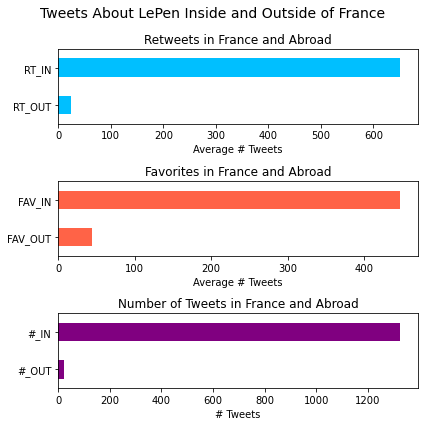

In [187]:
merged = avg_out_FR.join(avg_in_FR, how = 'outer')
merged.columns = ['RT_OUT', 'FAV_OUT','#_OUT','RT_IN', 'FAV_IN','#_IN']

fig, axs = plt.subplots(3)
fig.suptitle("Tweets About LePen Inside and Outside of France", fontsize = 14)

axs[0].set_title('Retweets in France and Abroad')
axs[0].set_xlabel('Average # Tweets')

axs[1].set_title('Favorites in France and Abroad')
axs[1].set_xlabel('Average # Tweets')

axs[2].set_title('Number of Tweets in France and Abroad')
axs[2].set_xlabel('# Tweets')

merged.iloc[0,[0,3]].plot.barh(ax = axs[0], color = 'deepskyblue')
merged.iloc[0,[1,4]].plot.barh(ax = axs[1], color = 'tomato')
merged.iloc[0,[2,5]].plot.barh(ax = axs[2], color = 'purple')

fig.set_size_inches(6,6)
plt.tight_layout()
plt.savefig('LePen.png')